# GAIA DR2 -- Parallax regeneration notebook


In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn
import torch.autograd as autograd
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib notebook

In [29]:
data_super_master = pd.read_csv('/bigdata1/gaia/dr2_panstars_clean.csv')

In [4]:
data_master = data_super_master.convert_objects()
data_master = data_master[data_super_master.select_dtypes(include=['float64','float32']).columns.tolist()]
data_master = data_master.astype('float64')
data_master.drop(data_master.isnull().sum().sort_values(ascending=False).loc[:'priam_flags'].index.tolist(), 1, inplace=True)
data_master.shape

(2000000, 69)

In [ ]:
targets = ['parallax']

features_first = [x for x in data_master.columns.tolist() \
 if  'id'          not in x   and 'index'                     not in x \
 and 'params'      not in x   and 'neighbour'                 not in x \
 and 'err'         not in x   
 and 'flag'        not in x \
 and '*error*'     not in x   
 and 'key'         not in x   and 'obs'                       not in x \
 and 'percentile'  not in x   and 'date'                      not in x \
 and 'sig'         not in x   and '_2'                        not in x \
 and '_3'          not in x   and '_4'                        not in x \
 and 'lum_val'     not in x   and 'e_bp_min_rp_val'           not in x \
 and 'a_g_val'     not in x   and 'teff_val'                  not in x \
 and 'astrometric' not in x   and 'frame_rotator_object_type' not in x \
 and 'ref_epoch'   not in x   and x not in targets 
 and 'number_of_mates' not in x ] 

data_train = data_master[data_master.parallax_over_error>5]
data_train = data_train[features_first + targets]

drop_cols = ['visibility_periods_used', 'rv_nb_transits']
data_train.drop(drop_cols, 1, inplace=True)

data_train.dropna(inplace=True)

features = [x for x in data_train.columns if x not in targets]

features = [\
#   'parallax_pmdec_corr',
#   'ra_pmra_corr',
#   'ra_parallax_corr',
#   'ra_dec_corr',
  'pmdec',
  'pmra',
  'ra',
  'dec',
  'bp_rp', 
  'bp_g', 
  'g_rp'
#   'w1mpro',
#   'w2mpro',
#   'w3mpro',
#   'w4mpro',
#   'w1mjd_mean',
#   'w2mjd_mean',
#   'w3mjd_mean',
#   'w4mjd_mean',
#   'ra_pmdec_corr',
#   'dec_parallax_corr',
#   'dec_pmra_corr',
#   'dec_pmdec_corr',
#   'parallax_pmra_corr',
#   'pmra_pmdec_corr',
]

print('Features being used for DeepGAIA: {}'.format(features))

data_train.dropna(inplace=True)
print(data_train[features + targets].shape)

X = data_train[features]
y = data_train[targets]

xmeans = X.mean()
xstds  = X.std()
X -= xmeans
X /= xstds

ymean = y.mean()
ystd  = y.std()
y -= ymean
y /= ystd

X = Variable(torch.from_numpy(X.values).type(torch.FloatTensor)).cuda()
y = Variable(torch.from_numpy(y.values).type(torch.FloatTensor)).cuda()

X_train = X #[:X.size(0)*1//2, :]
y_train = y #[:X.size(0)*1//2]

X_validation = X[X.size(0)*1//2:, :]
y_validation = y[X.size(0)*1//2:]

n_epochs = 800
n_hidden = 100

model = torch.nn.Sequential(
    torch.nn.Linear(X.size(1), n_hidden),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(n_hidden, n_hidden),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(n_hidden, y.size(1))).cuda()

solver = torch.optim.Adamax(model.parameters(), lr=1.0e-3)
criteria = torch.nn.SmoothL1Loss()

training_loss = []
validation_loss = []

for it in tqdm(range(n_epochs)):
    loss = criteria(model(X_train), y_train)
    loss.backward()
    solver.step()
    model.zero_grad()
    training_loss.append(loss.data)
    validation_loss.append(criteria(model(X_validation), y_validation).data)
    
training_loss_npy = [x.cpu().numpy() for x in training_loss]
validation_loss_npy = [x.cpu().numpy() for x in validation_loss]

fig, ax = plt.subplots(figsize=(7,5))
pd.Series(training_loss_npy).astype('float64').plot(lw=0.7, label='training loss', color='k');
pd.Series(validation_loss_npy).astype('float64').plot(lw=1.0,label='validation loss',color='r',ls='--');
ax.legend()
ax.set_ylabel('Smooth L1 Loss [relative units]')
ax.set_xlabel('Epochs')
ax.grid(alpha=0.1)

<IPython.core.display.Javascript object>


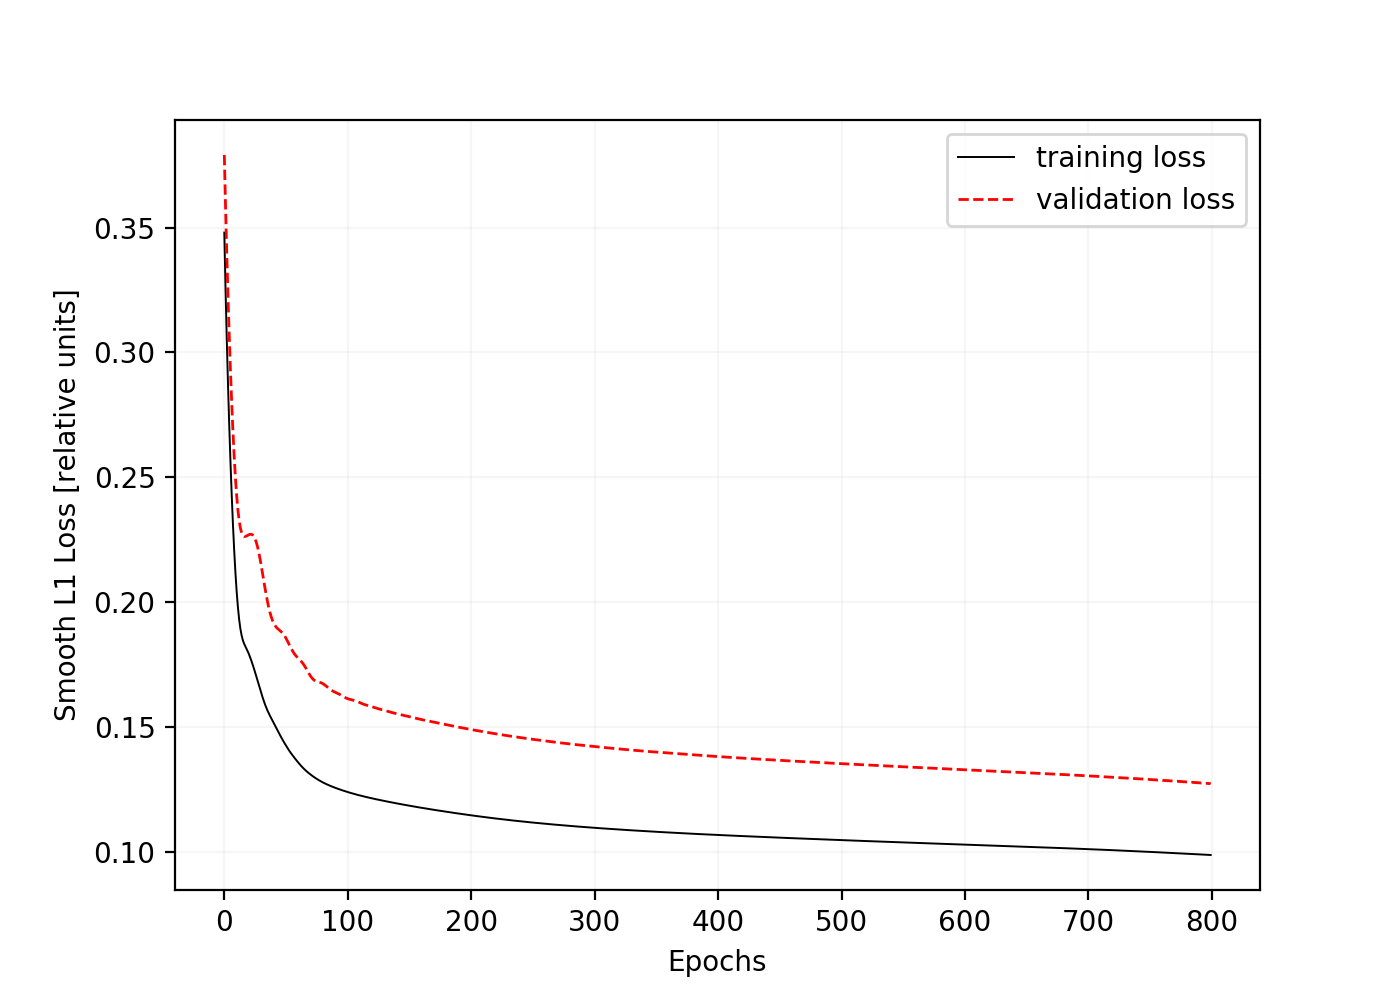

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
pd.Series(training_loss_npy).astype('float64').plot(lw=0.7, label='training loss', color='k');
pd.Series(validation_loss_npy).astype('float64').plot(lw=1.0,label='validation loss',color='r',ls='--');
ax.legend()
ax.set_ylabel('Smooth L1 Loss [relative units]')
ax.set_xlabel('Epochs')
ax.grid(alpha=0.1)

In [10]:
model_output = model(X_train).data.cpu().numpy()

parallax2 = model_output.flatten()
parallax2 = parallax2*ystd[0] + ymean[0]

data_train['parallax2'] =  pd.Series(parallax2, name='parallax2')
data_train['ABS G observed'] = data_train.phot_g_mean_mag - 5*np.log10(1000./data_train.parallax)  + 5.
data_train['ABS G DeepGaia'] = data_train.phot_g_mean_mag - 5*np.log10(1000./data_train.parallax2) + 5.

data_train.dropna(inplace=True)

## New color diagram with adjusted parallax

# Plots for paper 

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<IPython.core.display.Javascript object>


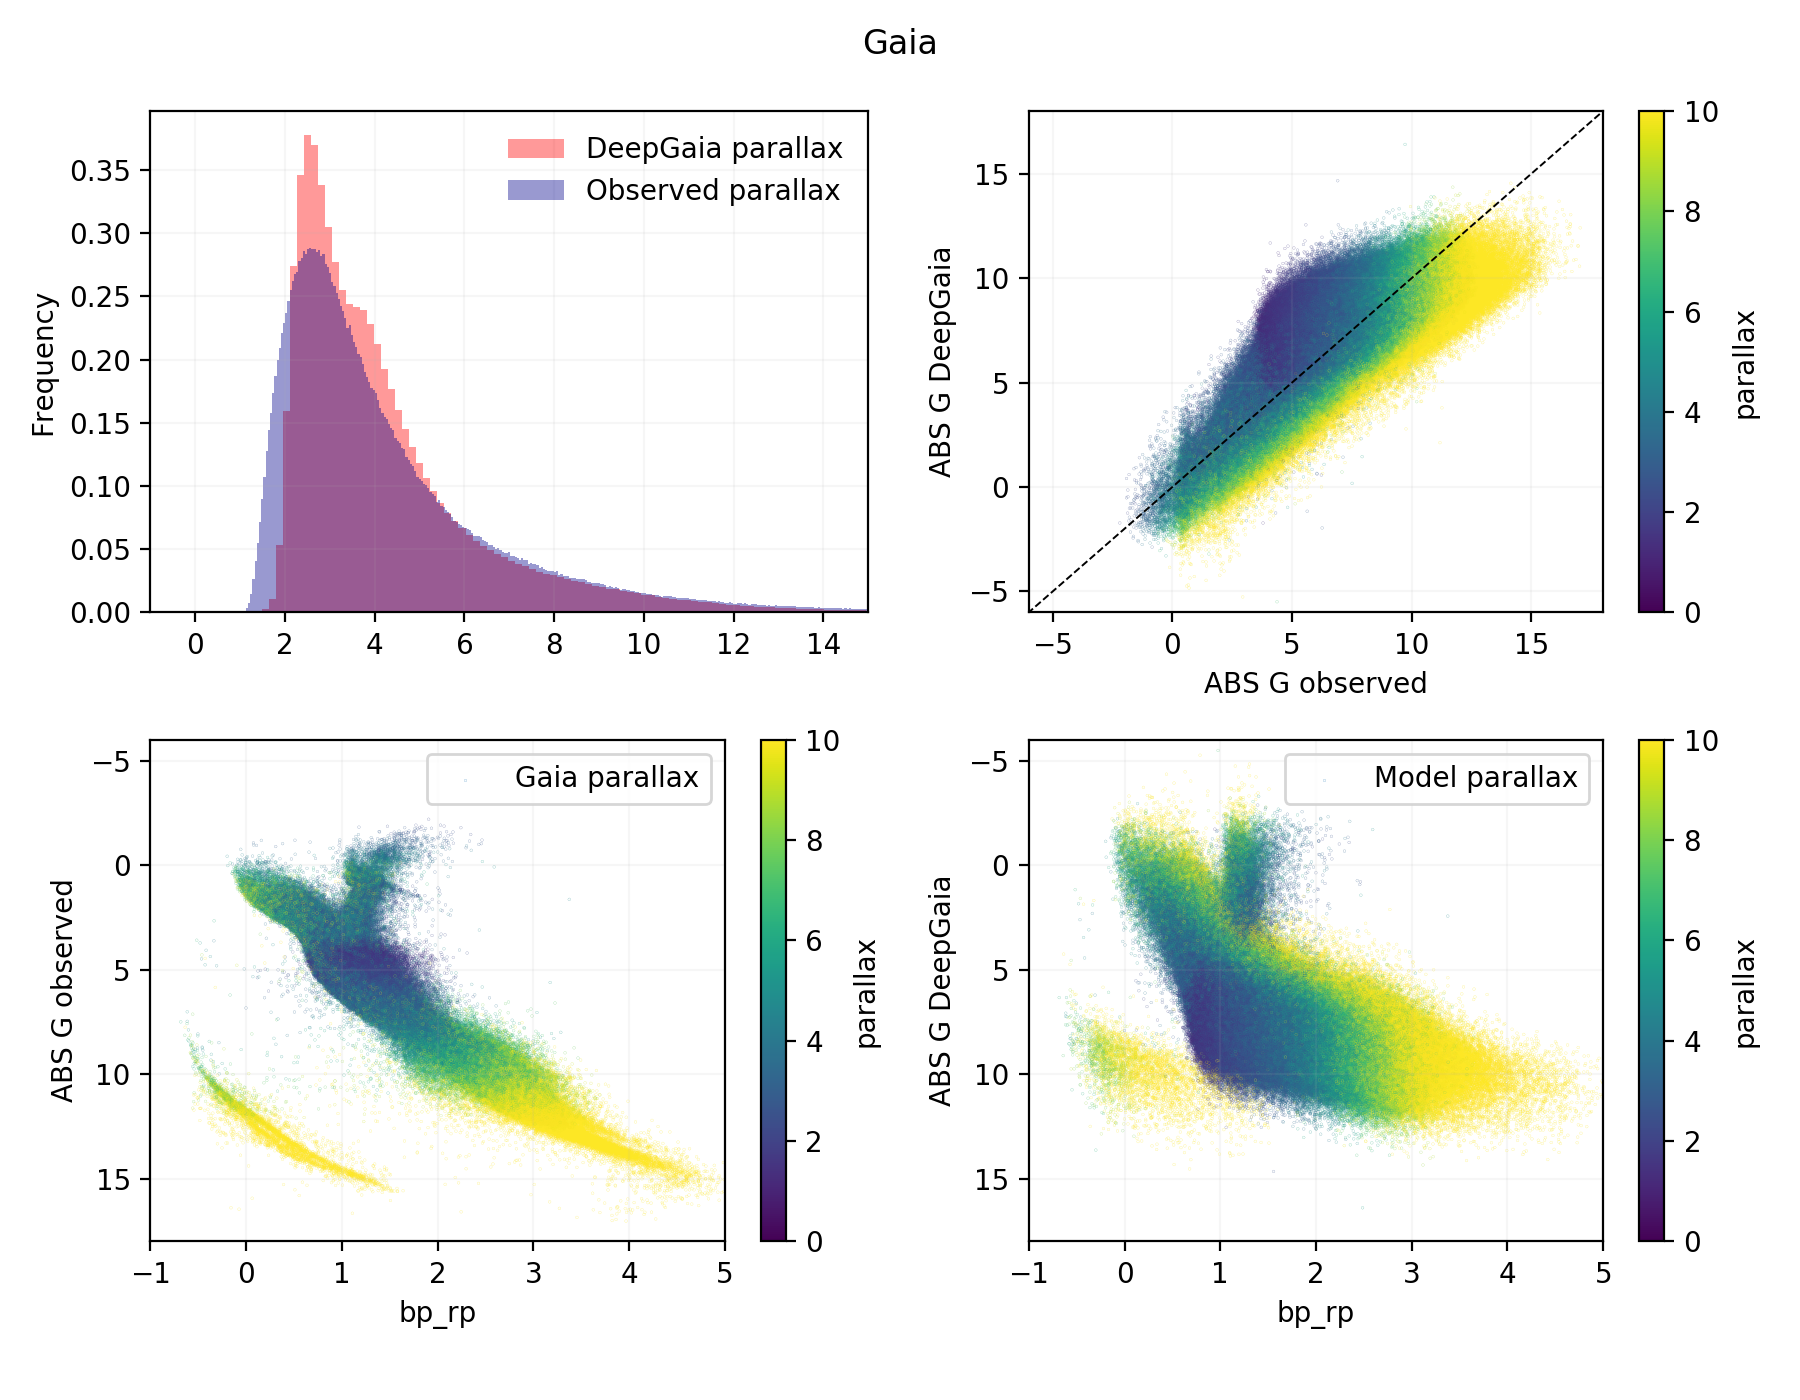

In [13]:
plot_gaia(data_train)

# Panstars sample

In [3]:
data_super_master = pd.read_csv('/bigdata1/gaia/dr2_panstars_clean.csv')
data_super_master = data_super_master.iloc[:,2:]

data = pd.DataFrame.copy(data_super_master)

print(data.shape)

(279201, 32)


In [12]:
data['g_i'] = data.g_mean_psf_mag - data.i_mean_psf_mag 
data['g_r'] = data.g_mean_psf_mag - data.r_mean_psf_mag
data['g_z'] = data.g_mean_psf_mag - data.z_mean_psf_mag
data['r_i'] = data.r_mean_psf_mag - data.i_mean_psf_mag

data['ABS G observed PANSTARS'] = data.g_mean_psf_mag - 5*np.log10(1000./data.parallax)  + 5.
data['ABS R observed PANSTARS'] = data.r_mean_psf_mag - 5*np.log10(1000./data.parallax)  + 5.

data['ABS G observed GAIA'] = data.phot_g_mean_mag - 5*np.log10(1000./data.parallax)  + 5.

In [8]:
fig, ax = plt.subplots(figsize=(18,6), ncols=2)

data.plot(kind='scatter', ax=ax[0], x='g_i', y='ABS G observed PANSTARS', s=0.09, c='parallax', cmap='viridis', vmin=0, vmax=25)
data.plot(kind='scatter', ax=ax[1], x='g_i', y='ABS G observed PANSTARS', s=0.09, c='parallax_over_error', cmap='viridis', vmin=100, vmax=600)

for axes in ax:
    axes.set_ylim(17, -1); 
    axes.set_xlim(-6, 6)
    axes.grid(alpha=0.1)

<IPython.core.display.Javascript object>

In [9]:
fig, ax = plt.subplots(figsize=(18,6), ncols=2)

data.plot(kind='scatter', ax=ax[0], x='g_r', y='ABS G observed PANSTARS', s=0.09, c='parallax', cmap='viridis', vmin=0, vmax=25)
data.plot(kind='scatter', ax=ax[1], x='g_r', y='ABS G observed PANSTARS', s=0.09, c='parallax_over_error', cmap='viridis', vmin=100, vmax=600)

for axes in ax:
    axes.set_ylim(21, -1); 
    axes.set_xlim(-6, 6)
    axes.grid(alpha=0.1)

<IPython.core.display.Javascript object>

In [14]:
%matplotlib inline

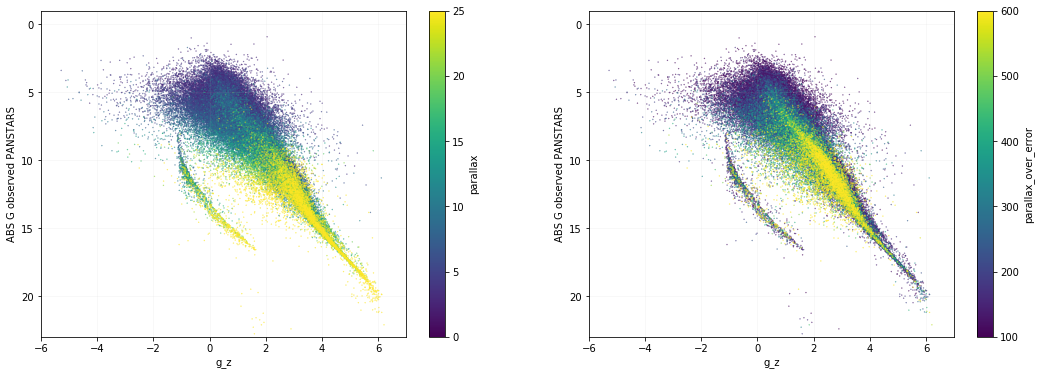

In [15]:
fig, ax = plt.subplots(figsize=(22,7), ncols=2)

data.plot(kind='scatter', ax=ax[0], x='g_z', y='ABS G observed PANSTARS', s=0.09, c='parallax', cmap='viridis', vmin=0, vmax=25)
data.plot(kind='scatter', ax=ax[1], x='g_z', y='ABS G observed PANSTARS', s=0.09, c='parallax_over_error', cmap='viridis', vmin=100, vmax=600)

for axes in ax:
    axes.set_ylim(23, -1); 
    axes.set_xlim(-6, 7)
    axes.grid(alpha=0.1)

In [11]:
data.columns.tolist()

['ra',
 'dec',
 'g_mean_psf_mag',
 'r_mean_psf_mag',
 'i_mean_psf_mag',
 'z_mean_psf_mag',
 'y_mean_psf_mag',
 'g_mean_psf_mag_error',
 'r_mean_psf_mag_error',
 'i_mean_psf_mag_error',
 'z_mean_psf_mag_error',
 'y_mean_psf_mag_error',
 'parallax',
 'parallax_over_error',
 'pmra',
 'pmdec',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'phot_g_mean_mag',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'bp_rp',
 'bp_g',
 'g_rp',
 'g_i',
 'g_r',
 'r_i',
 'ABS G observed PANSTARS',
 'ABS R observed PANSTARS',
 'ABS G observed GAIA']

In [ ]:
fig, ax = plt.subplots(figsize=(18,6), ncols=2)

data.plot(kind='scatter', ax=ax[0], x='g_r', y='ABS G observed PANSTARS', s=0.09, c='parallax', cmap='viridis', vmin=0, vmax=25)
data.plot(kind='scatter', ax=ax[1], x='g_r', y='ABS G observed PANSTARS', s=0.09, c='parallax_over_error', cmap='viridis', vmin=100, vmax=600)

for axes in ax:
    axes.set_ylim(21, -1); 
    axes.set_xlim(-6, 6)
    axes.grid(alpha=0.1)

<IPython.core.display.Javascript object>


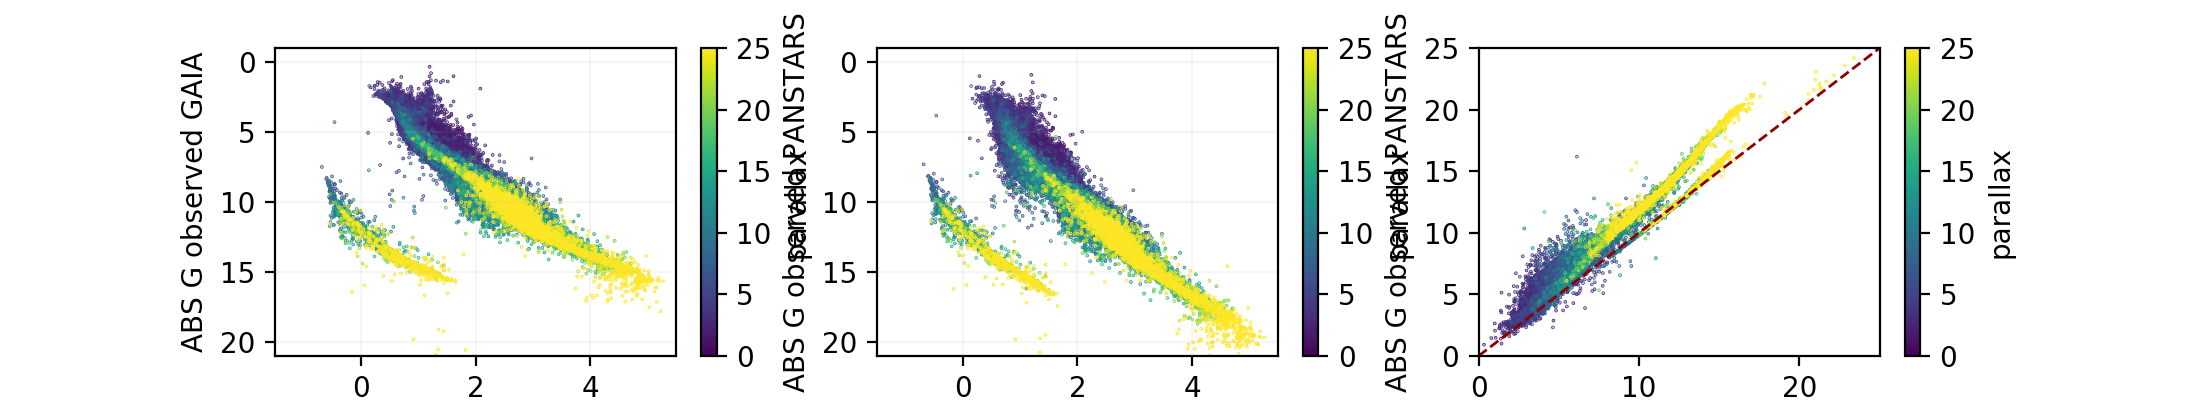

In [6]:
fig, ax = plt.subplots(figsize=(22//2,5//2), ncols=3)

data.plot(kind='scatter', ax=ax[0], x='bp_rp', y='ABS G observed GAIA', s=0.09, c='parallax', cmap='viridis', vmin=0, vmax=25)
data.plot(kind='scatter', ax=ax[1], x='bp_rp', y='ABS G observed PANSTARS', s=0.09, c='parallax', cmap='viridis', vmin=0, vmax=25)

data.plot(kind='scatter', ax=ax[2], x='ABS G observed GAIA', y='ABS G observed PANSTARS', s=0.09, c='parallax', cmap='viridis', vmin=0, vmax=25)
ax[2].plot([0,25], [0,25], lw=1.0, ls='--', color='darkred')
ax[2].set_xlim(0,25); ax[2].set_ylim(0,25)

for axes in ax[:-1]:
    axes.set_ylim(21, -1); 
    axes.set_xlim(-1.5, 5.5)
    axes.grid(alpha=0.1)

<IPython.core.display.Javascript object>


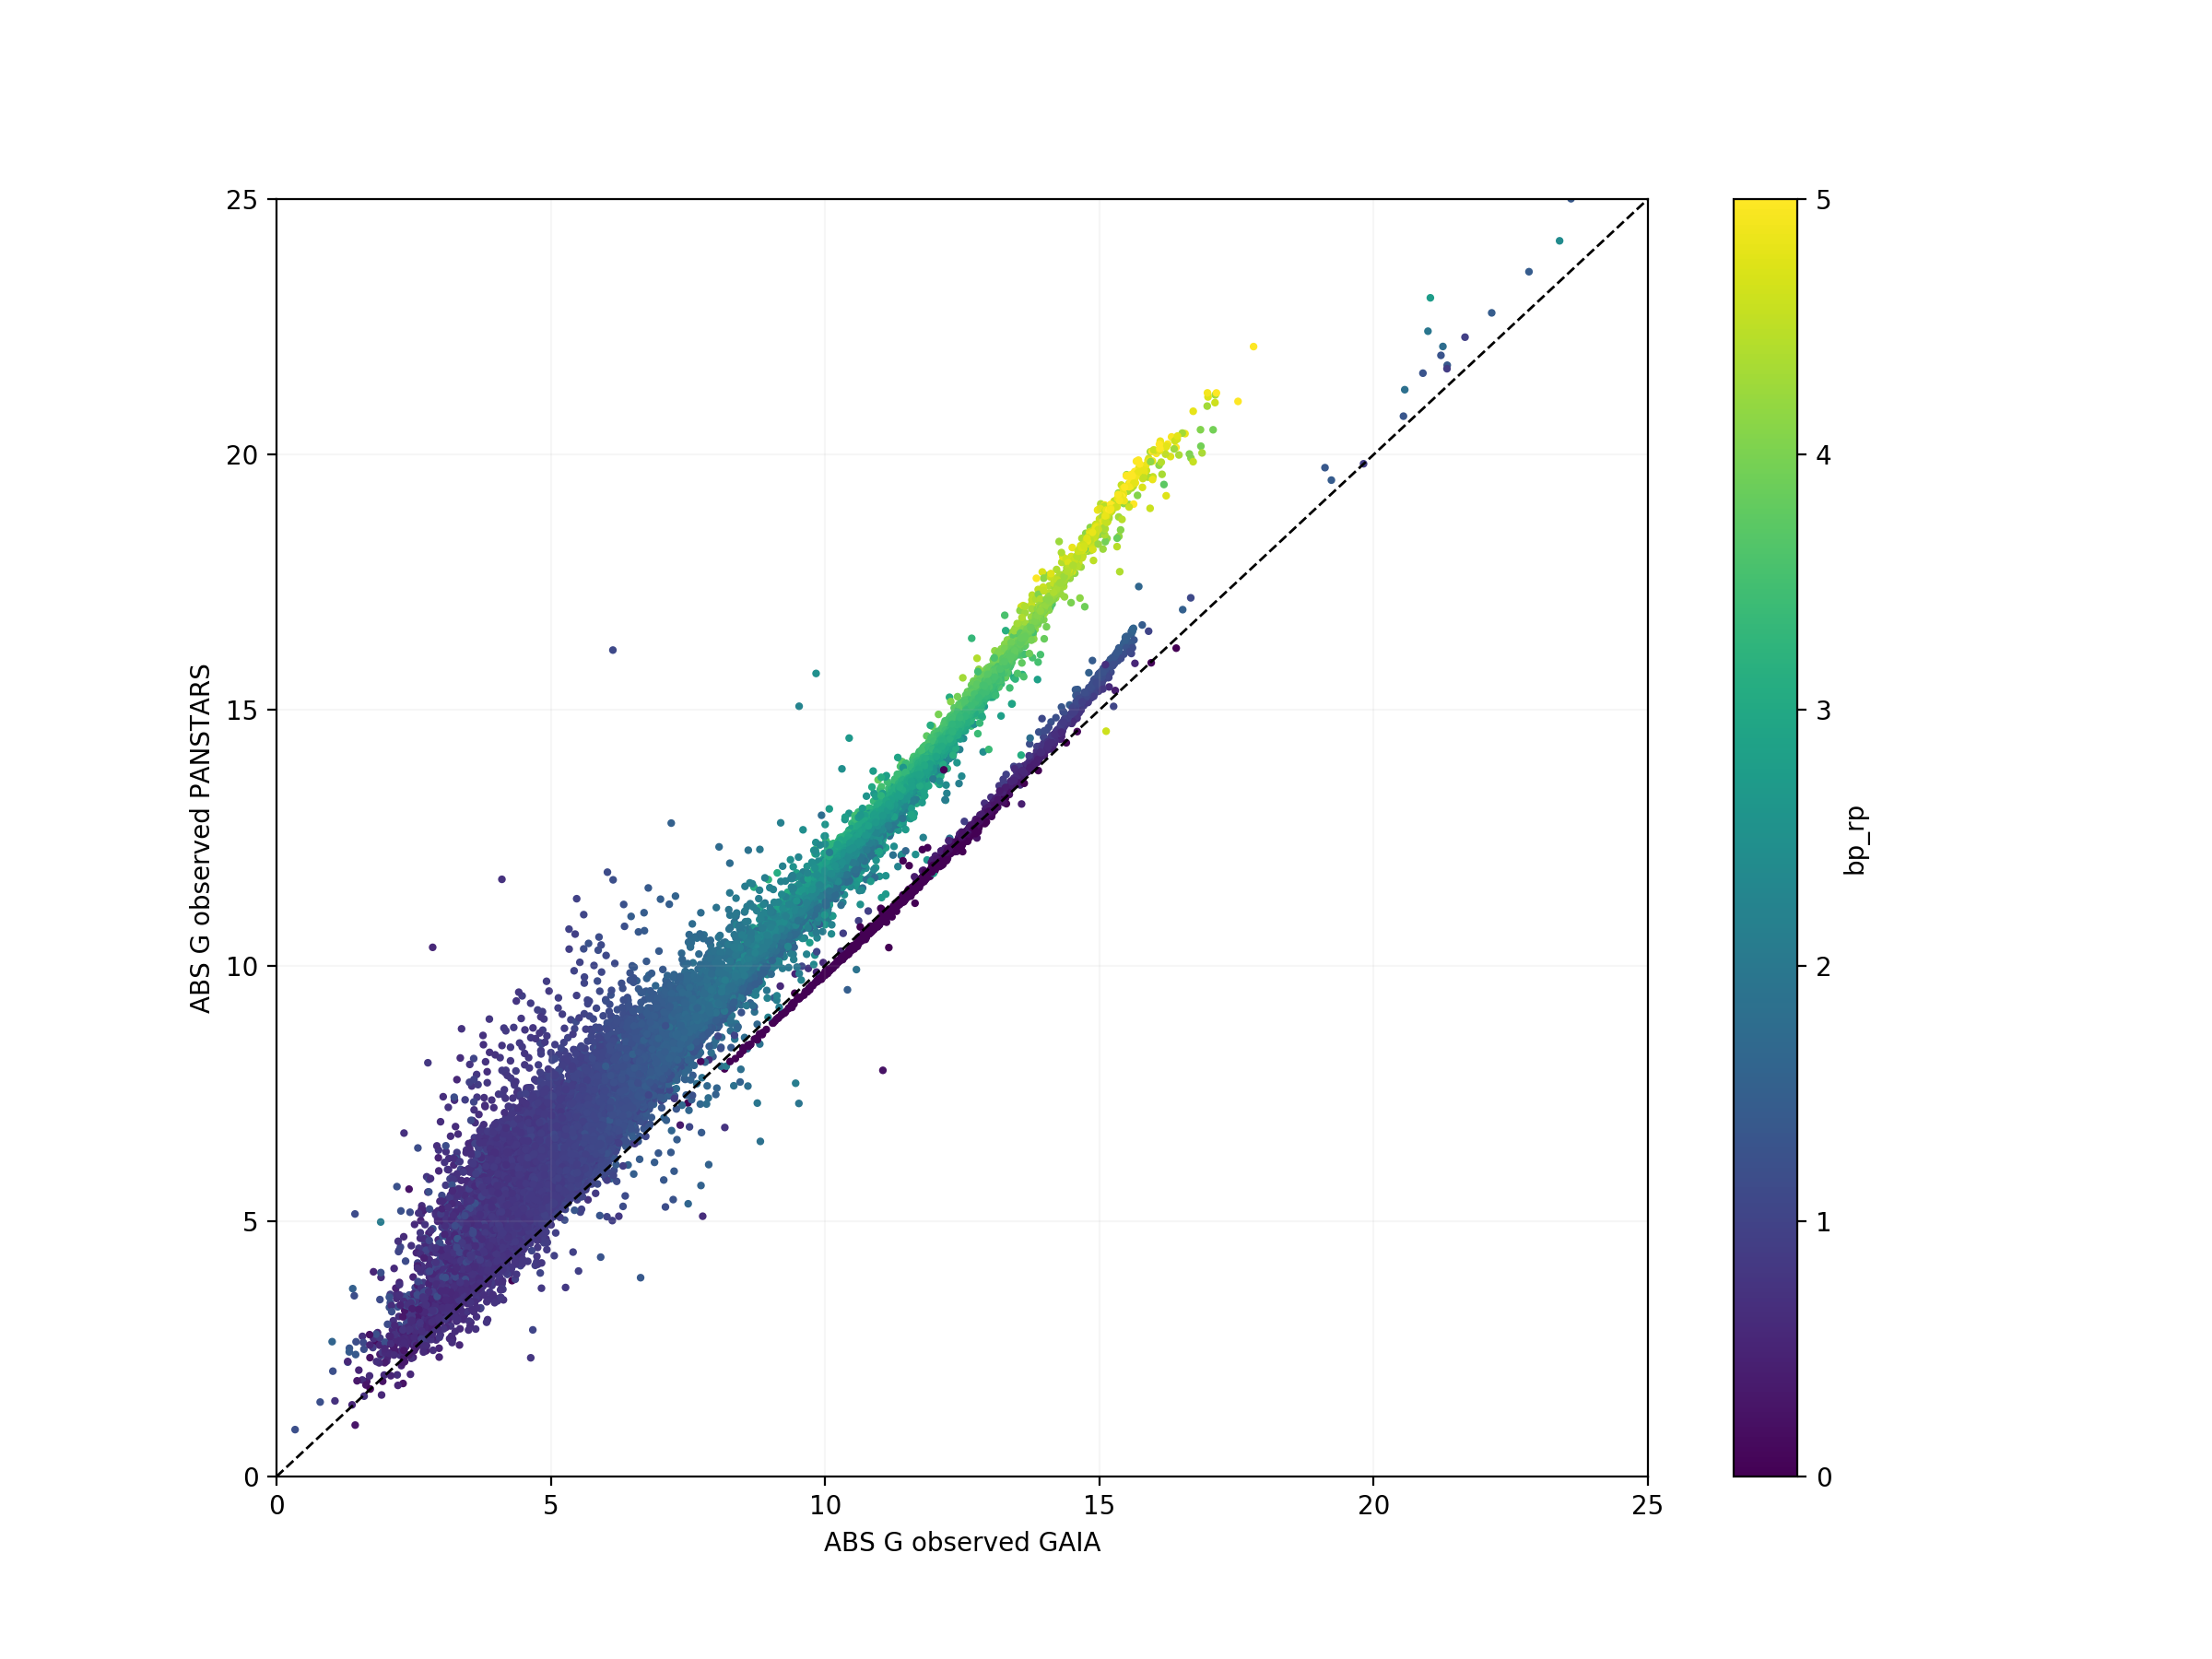

In [203]:
fig, ax = plt.subplots(figsize=(12,9))

data.plot(kind='scatter', ax=ax, x='ABS G observed GAIA', y='ABS G observed PANSTARS', s=4.0, c='bp_rp', cmap='viridis', vmin=0, vmax=5)
ax.plot([0,25], [0,25], lw=1.0, ls='--', color='k')
ax.set_xlim(0,25); ax.set_ylim(0,25)
ax.grid(alpha=0.1)

--------------- DeepGAIA ---------------

Features used for training:
['ra', 'dec', 'g_mean_psf_mag', 'r_mean_psf_mag', 'i_mean_psf_mag', 'z_mean_psf_mag', 'y_mean_psf_mag', 'parallax_over_error', 'pmra', 'pmdec', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp']
Number of samples used for training: 596244

Architecture of model being used:

Sequential(
  (0): Linear(in_features=26, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=100, out_features=1, bias=True)
)

Number of epochs: 400


<IPython.core.display.Javascript object>


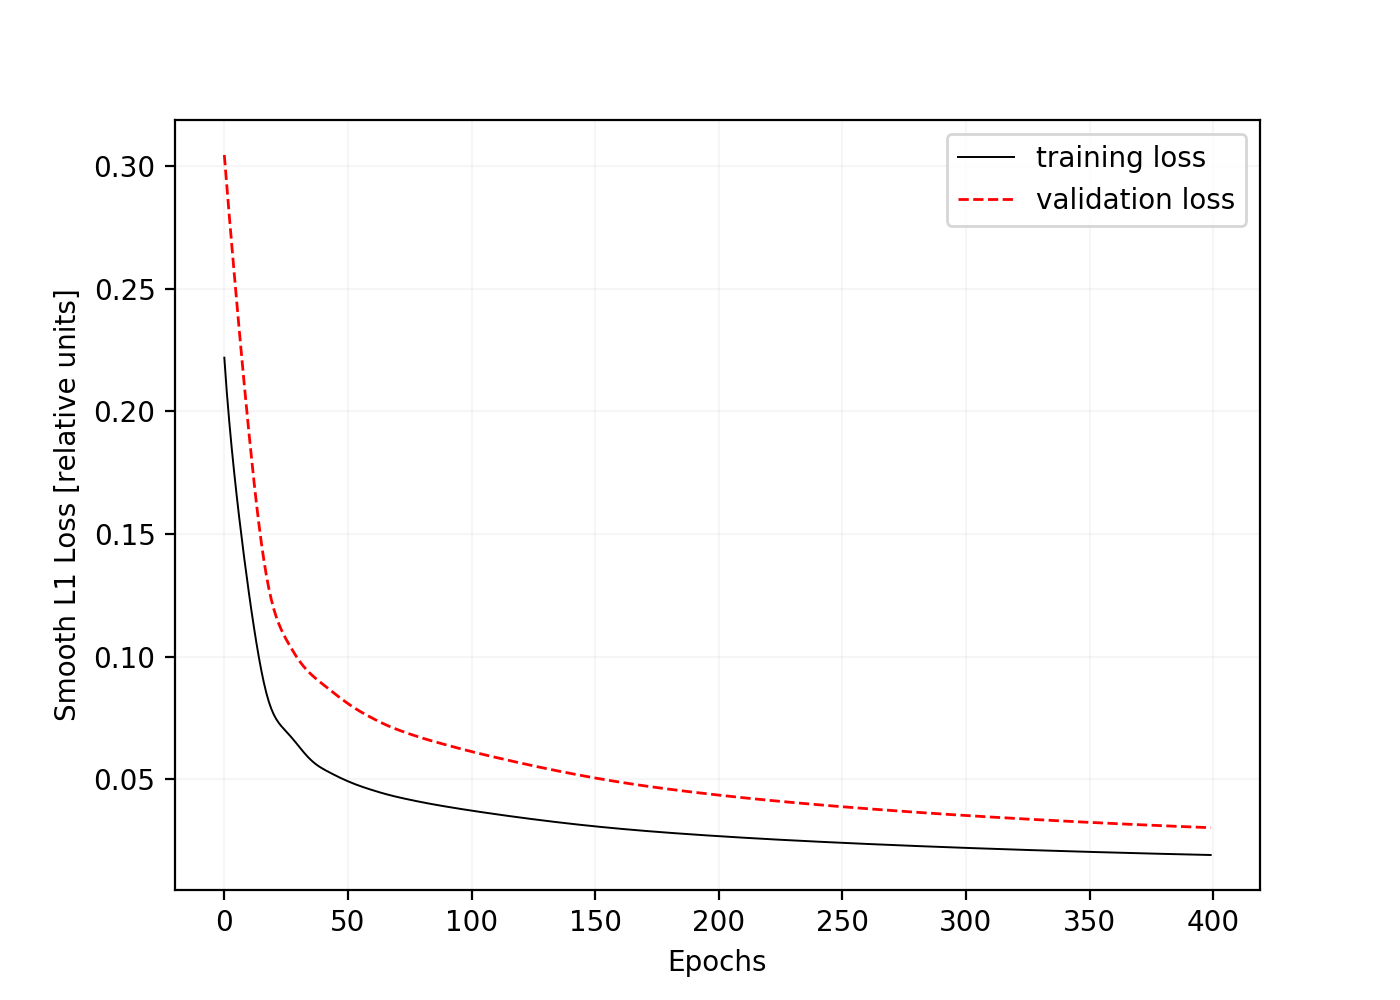

<IPython.core.display.Javascript object>


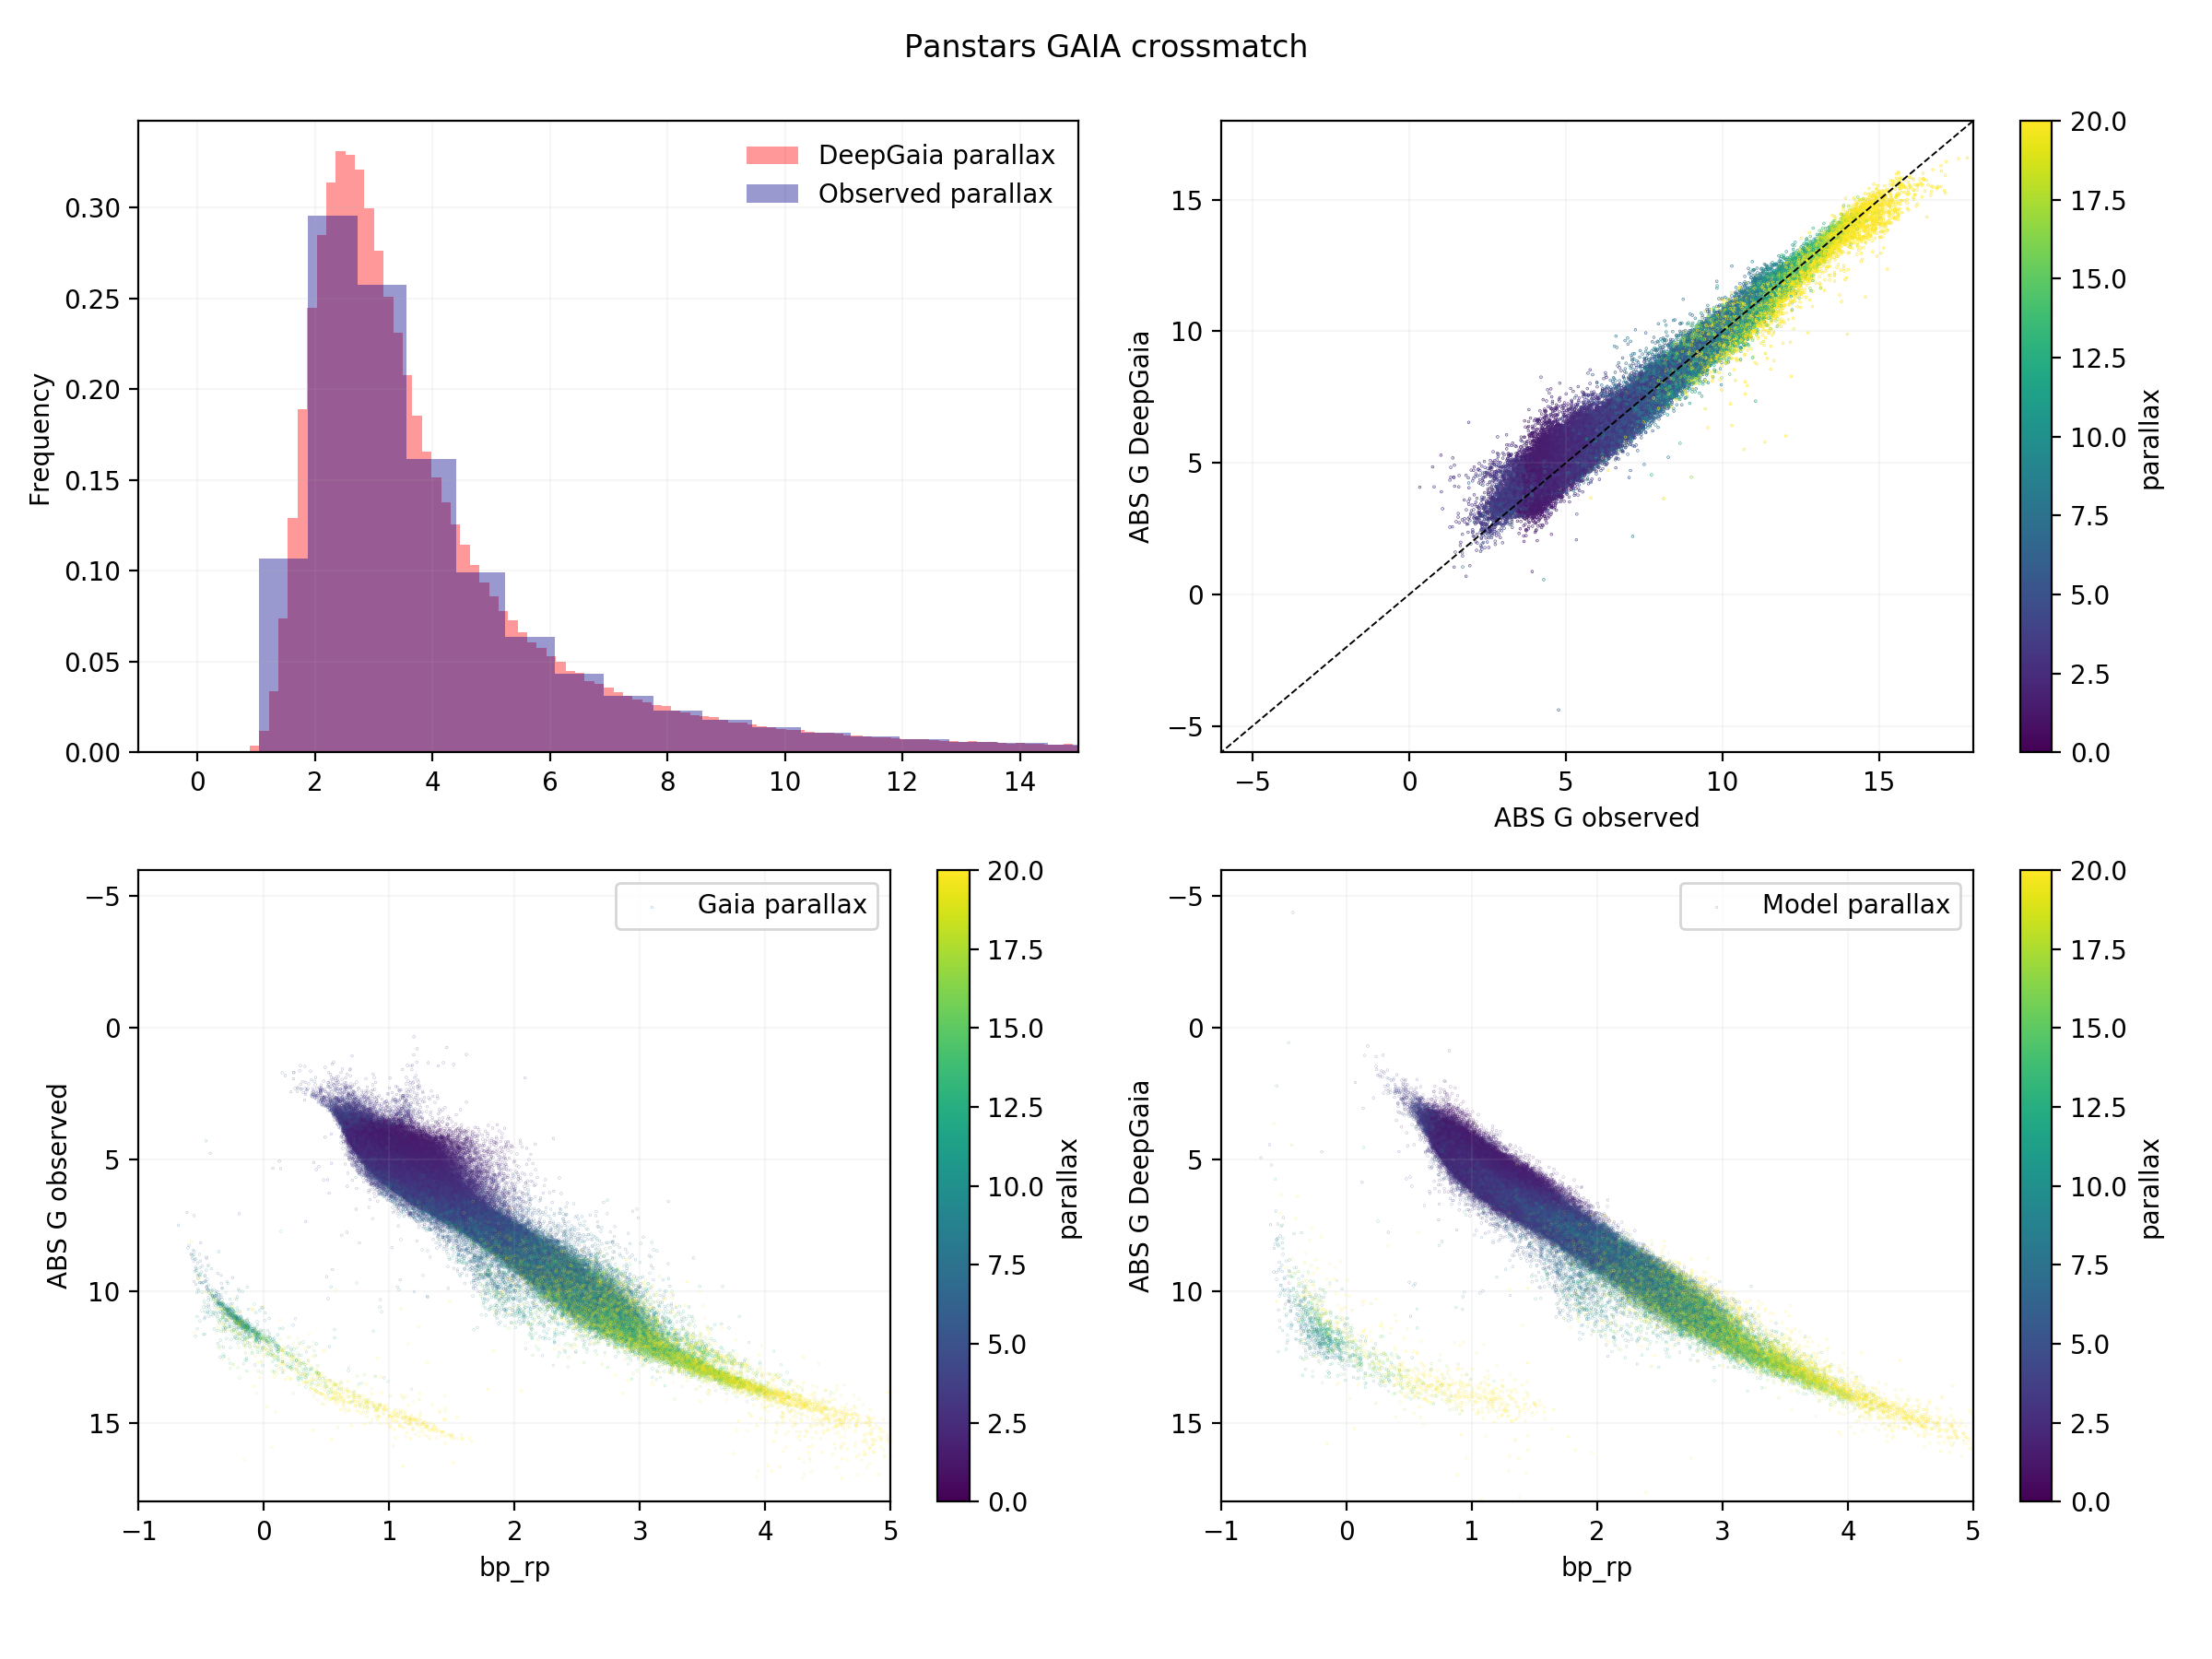

In [55]:
data_train = pd.DataFrame.copy(data_super_master)

targets = ['parallax']
features = [x for x in data_train.columns if x not in targets]

# features = ['ra','dec',
#  'g_mean_psf_mag',
#  'r_mean_psf_mag',
#  'i_mean_psf_mag',
#  'z_mean_psf_mag',
#  'y_mean_psf_mag']

print('--------------- DeepGAIA ---------------')
print('')
print('Features used for training:')
print(features)
print('Number of samples used for training: {}'.format(data_train.shape[0]))

X = data_train[features]
y = data_train[targets]

xmeans = X.mean()
xstds  = X.std()
X -= xmeans
X /= xstds

ymean = y.mean()
ystd  = y.std()
y -= ymean
y /= ystd

X = Variable(torch.from_numpy(X.values).type(torch.FloatTensor)).cuda()
y = Variable(torch.from_numpy(y.values).type(torch.FloatTensor)).cuda()

X_train = X #[:X.size(0)*1//2, :]
y_train = y #[:X.size(0)*1//2]

X_validation = X[X.size(0)*1//2:, :]
y_validation = y[X.size(0)*1//2:]

n_epochs = 400
n_hidden = 100

model = torch.nn.Sequential(
    torch.nn.Linear(X.size(1), n_hidden),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(n_hidden, n_hidden),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(n_hidden, y.size(1))).cuda()

print('')
print('Architecture of model being used:')
print('')
print(model)
print('')
print('Number of epochs: {}'.format(n_epochs))

solver = torch.optim.Adamax(model.parameters(), lr=1.0e-3)
criteria = torch.nn.SmoothL1Loss()

training_loss = []
validation_loss = []

for it in tqdm(range(n_epochs)):
    loss = criteria(model(X_train), y_train)
    loss.backward()
    solver.step()
    model.zero_grad()
    training_loss.append(loss.data)
    validation_loss.append(criteria(model(X_validation), y_validation).data)
    
training_loss_npy = [x.cpu().numpy() for x in training_loss]
validation_loss_npy = [x.cpu().numpy() for x in validation_loss]

fig, ax = plt.subplots(figsize=(7,5))
pd.Series(training_loss_npy).astype('float64').plot(lw=0.7, label='training loss', color='k');
pd.Series(validation_loss_npy).astype('float64').plot(lw=1.0,label='validation loss',color='r',ls='--');
ax.legend()
ax.set_ylabel('Smooth L1 Loss [relative units]')
ax.set_xlabel('Epochs')
ax.grid(alpha=0.3)

model_output = model(X_train).data.cpu().numpy()
parallax2 = model_output.flatten()
parallax2 = parallax2*ystd[0] + ymean[0]

data_train['parallax2'] =  pd.Series(parallax2, name='parallax2')
data_train['ABS G observed'] = data_train.phot_g_mean_mag - 5*np.log10(1000./data_train.parallax)  + 5.
data_train['ABS G DeepGaia'] = data_train.phot_g_mean_mag - 5*np.log10(1000./data_train.parallax2) + 5.

data_train.dropna(inplace=True)

plot_gaia(data_train, sample_size=data_train.shape[0], title='Panstars GAIA crossmatch')

# Make predictions on low SNR 

In [56]:
data_super_master_unclean = pd.read_csv('/bigdata1/gaia/dr2_panstars_unclean.csv')

In [57]:
data_pred = data_super_master_unclean[data_super_master_unclean.parallax_over_error.between(0,30)]
data_pred = data_pred.loc[data_pred[features].dropna().index, data_train.columns]

X_pred = data_pred[features]
X_pred -= xmeans
X_pred /= xstds

X_pred = Variable(torch.from_numpy(X_pred.values).type(torch.FloatTensor)).cuda()
model_output = model(X_pred).data.cpu().numpy()

parallax2 = model_output.flatten()
parallax2 = parallax2*ystd[0] + ymean[0]

data_pred['parallax2'] =  pd.Series(parallax2, name='parallax2')
data_pred['ABS G observed'] = data_pred.phot_g_mean_mag - 5*np.log10(1000./data_pred.parallax)  + 5.
data_pred['ABS G DeepGaia'] = data_pred.phot_g_mean_mag - 5*np.log10(1000./data_pred.parallax2) + 5.

data_pred.dropna(inplace=True)

In [69]:
data_pred[data_pred.parallax_over_error.between(3,5)].shape

(272465, 30)

In [83]:
plot_gaia(data_pred[data_pred.parallax_over_error.between(0,2)], sample_size=50000, title='Panstars predictions')

<IPython.core.display.Javascript object>

# function defs:

In [82]:
def plot_gaia(data, title='', sample_size=10000):

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,9))
    sample_size = sample_size #data.shape[0]

    data.parallax2.sample(sample_size).plot(kind='hist', bins=800, ax=ax[0,0], label='DeepGaia parallax', alpha=0.4, normed=True, color='r')
    data.parallax.sample(sample_size).plot( kind='hist', bins=800, ax=ax[0,0], label='Observed parallax',  alpha=0.4, normed=True, color='darkblue')
    ax[0,0].legend(fontsize=10, frameon=False); ax[0,0].set_xlim(-1,15);

    data.sample(sample_size).plot(kind='scatter', ax=ax[0,1], x='parallax', y='parallax2', s=0.04, c='parallax', cmap='viridis', vmin=0, vmax=25)
    ax[0,1].plot([-20,20],[-20,20], ls='--', lw=0.7, color='k'); 
    ax[0,1].set_xlim(-6,18); ax[0,1].set_ylim(-6,18)

    data.sample(sample_size).plot(kind='scatter', ax=ax[1,0], x='bp_rp', y='ABS G observed', s=0.004, label='Gaia parallax', 
                                  c='parallax', cmap='viridis', vmin=0, vmax=20)
    ax[1,0].set_ylim(18, -6); ax[1,0].set_xlim(-1, 5)

    data.sample(sample_size).plot(kind='scatter', ax=ax[1,1], x='bp_rp', y='ABS G DeepGaia', s=0.004, label='Model parallax', 
                                  c='parallax', cmap='viridis', vmin=0, vmax=20)
    ax[1,1].set_ylim(18, -6); ax[1,1].set_xlim(-1, 5)

    for axes in ax:
        for axax in axes:
            axax.grid(alpha=0.1)

    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])